# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import os
from agents.maddpg.maddpg import MADDPG
import matplotlib.pyplot as plt
from torchsummary import summary
%load_ext autoreload
%autoreload 2
torch.cuda.is_available()

using device: cuda
using device: cuda
using device: cuda


True

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance. If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.x86_64")
```

In [2]:
env = UnityEnvironment(file_name="./simulation_env/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [19]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
maddpg = MADDPG(num_agents, state_size, action_size, random_seed=0)

In [6]:
# Actor architecture
summary(maddpg.maddpg_agents[0].actor_local, input_size=(24,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]           7,500
       BatchNorm1d-2                  [-1, 300]             600
            Linear-3                  [-1, 200]          60,200
            Linear-4                    [-1, 2]             402
Total params: 68,702
Trainable params: 68,702
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.26
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [7]:
# Critic architecture
summary(maddpg.maddpg_agents[0].critic_local, input_size=[(52,),(0,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]          15,900
       BatchNorm1d-2                  [-1, 300]             600
            Linear-3                  [-1, 200]          60,200
            Linear-4                    [-1, 1]             201
Total params: 76,901
Trainable params: 76,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.29
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [7]:
N_EPISODES = 10000
RECORD_EVERY = 100
MAX_T = 1000

scores_queue = deque(maxlen=100)
scores_avg = []
scores = []
goal_flag = False
for episode in range(1, N_EPISODES+1):
    rewards = []
    env_info = env.reset(train_mode=True)[brain_name]    # reset the environment    
    state = env_info.vector_observations                  # get the current state (for each agent)

    # loop over steps
    for t in range(MAX_T):
        # select an action
        action = maddpg.act(state)
        # take action in environment and set parameters to new values
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        rewards_vec = env_info.rewards
        done = env_info.local_done
        # update and train agent with returned information
        maddpg.step(state, action, rewards_vec, next_state, done)
        state = next_state
        rewards.append(rewards_vec)
        if any(done):
            break

    # calculate episode reward as maximum of individually collected rewards of agents
    episode_reward = np.max(np.sum(np.array(rewards),axis=0))
        
    scores.append(episode_reward)             # save most recent score to overall score array
    scores_queue.append(episode_reward)       # save most recent score to running window of 100 last scores
    current_avg_score = np.mean(scores_queue)
    scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array
    
    print(f'\rEpisode: {episode}\tLast 100-Average Score: {current_avg_score:.3f}', end="")
    
    # save model every RECORD_EVERY episodes
    if episode % RECORD_EVERY == 0:
        print('\rEpisode {}\tLast 100-Average Score: {:.3f}'.format(episode, current_avg_score))
        for i, ddpg_agent in enumerate(maddpg.maddpg_agents):
            torch.save(ddpg_agent.actor_local.state_dict(), f'./checkpoints/checkpoint_{episode}_actor_agent{i}.pth')
            torch.save(ddpg_agent.critic_local.state_dict(), f'./checkpoints/checkpoint_{episode}_critic_agent{i}.pth')

    # record model success if problem is solved
    if current_avg_score >= 0.5 and not goal_flag:
        goal_flag = True
        print(f'\nProblem solved in {episode} episodes, saving model...')
        for i, ddpg_agent in enumerate(maddpg.maddpg_agents):
            torch.save(ddpg_agent.actor_local.state_dict(), f'./checkpoints/solved_checkpoint_{episode}_actor_agent{i}.pth')
            torch.save(ddpg_agent.critic_local.state_dict(), f'./checkpoints/solved_checkpoint_{episode}_critic_agent{i}.pth')

    # break and record model if problem reaches a better goal than 1.0
    if current_avg_score >= 1.0:
        print(f'\nProblem reached more than 1.0 in {episode} episodes, saving model...')
        for i, ddpg_agent in enumerate(maddpg.maddpg_agents):
            torch.save(ddpg_agent.actor_local.state_dict(), f'./checkpoints/solved_checkpoint_{episode}_actor_agent{i}.pth')
            torch.save(ddpg_agent.critic_local.state_dict(), f'./checkpoints/solved_checkpoint_{episode}_critic_agent{i}.pth')
        break

Episode 100	Last 100-Average Score: 0.0155
Episode 200	Last 100-Average Score: 0.0133
Episode 300	Last 100-Average Score: 0.0277
Episode 400	Last 100-Average Score: 0.0111
Episode 500	Last 100-Average Score: 0.0255
Episode 600	Last 100-Average Score: 0.0722
Episode 700	Last 100-Average Score: 0.0711
Episode 800	Last 100-Average Score: 0.0911
Episode 900	Last 100-Average Score: 0.1244
Episode 1000	Last 100-Average Score: 0.1355
Episode 1100	Last 100-Average Score: 0.3700
Episode: 1139	Last 100-Average Score: 0.504
Problem solved in 1139 episodes, saving model...
Episode 1200	Last 100-Average Score: 0.6333
Episode 1300	Last 100-Average Score: 0.9855
Episode: 1317	Last 100-Average Score: 1.004
Problem reached more than 1.0 in 1317 episodes, saving model...


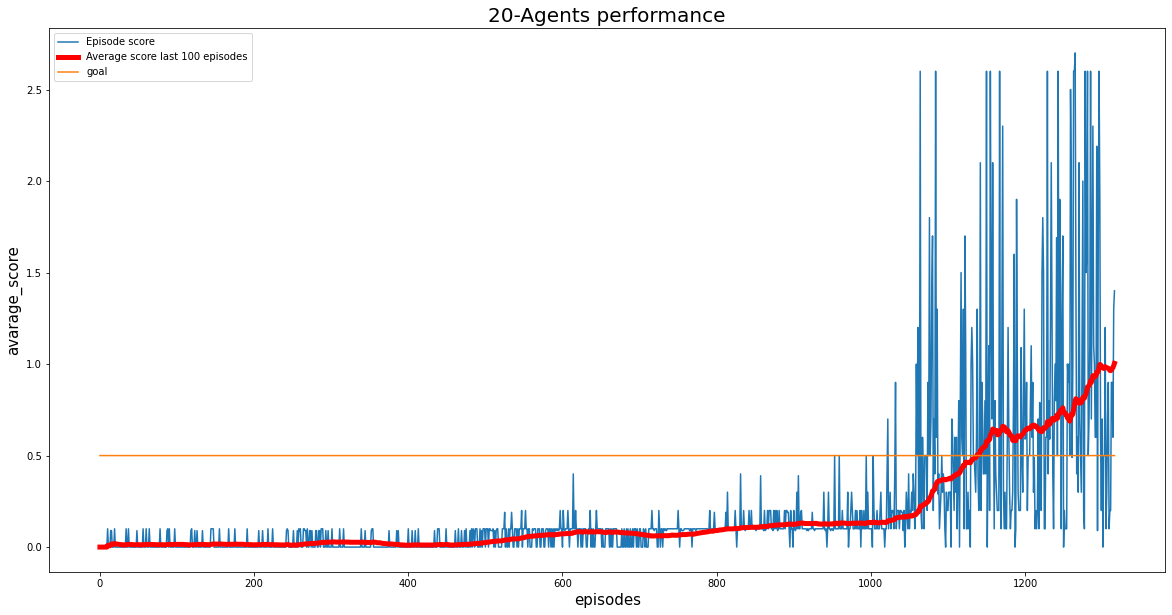

In [8]:
from turtle import color


plt.figure(figsize=(20,10))
plt.plot(scores)
plt.plot(scores_avg, color='red', linewidth=5)
plt.plot([0.5]*len(scores_avg))
plt.xlabel('episodes', fontsize = 15)
plt.ylabel('avarage_score', fontsize = 15)
plt.title('20-Agents performance', fontsize = 20)
plt.legend(['Episode score', 'Average score last 100 episodes', 'goal'])
plt.show()

# Inference

In [11]:
# Inference for 1 episode
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = maddpg.act(states)                       # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Score for one episode: {}'.format(np.max(scores)))

Score for one episode: 1.0000000149011612
